In [2]:
import pickle
import torch
import copy
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import torchvision.models as models
import torchsummary

from skimage import io
from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path
from torchvision import transforms
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from torch.utils.data import Dataset, DataLoader
from matplotlib import colors, pyplot as plt
%matplotlib inline

train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
torch.cuda.is_available()

CUDA is available!  Training on GPU ...


True

In [3]:
DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 224
DEVICE = torch.device("cuda")
EPOCHS=30
BATCH_SIZE=64
N_FOLDS = 2

SEED = 69
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform_list = []
        transform_list.append(transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)))
        if self.mode != 'test':            
            transform_list.append(transforms.RandomHorizontalFlip())
            transform_list.append(transforms.RandomRotation(15))
        transform_list.append(transforms.ToTensor())
        transform_list.append(transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]))
        
        transform = transforms.Compose(transform_list)
        x = self.load_sample(self.files[index])
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

In [5]:
def create_dct_path_labels(train_val_files, train_val_labels):
    dct_simpsons = {}
    for label_i in np.unique(train_val_labels).tolist():
        dct_simpsons[label_i] = []

    for path_i, label_i in zip(train_val_files, train_val_labels):
        dct_simpsons[label_i].append(path_i)

    return dct_simpsons

In [10]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))
train_val_labels = [path.parent.name for path in train_val_files]

dct_train_val = {}
dct_train_val = create_dct_path_labels(train_val_files, train_val_labels)

#dct_simpsons_wht = {}
#for key in dct_train_val:
#    dct_simpsons_wht.update({key:1. / dct_train_val[key]})
    
train_val_dataset = SimpsonsDataset(train_val_files, mode='val')

In [27]:
class_counts = [len(dct_train_val[char]) for char in dct_train_val]
num_samples = sum(class_counts)
labels = train_val_labels

class_weights = [num_samples/class_counts[i] for i in range(len(class_counts))]
weights = [class_weights[labels[i]] for i in range(int(num_samples))]
sampler = WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples))

TypeError: list indices must be integers or slices, not str

In [28]:
labels

['abraham_grampa_simpson',
 'abraham_grampa_simpson',
 'abraham_grampa_simpson',
 'abraham_grampa_simpson',
 'abraham_grampa_simpson',
 'abraham_grampa_simpson',
 'abraham_grampa_simpson',
 'abraham_grampa_simpson',
 'abraham_grampa_simpson',
 'abraham_grampa_simpson',
 'abraham_grampa_simpson',
 'abraham_grampa_simpson',
 'abraham_grampa_simpson',
 'abraham_grampa_simpson',
 'abraham_grampa_simpson',
 'abraham_grampa_simpson',
 'abraham_grampa_simpson',
 'abraham_grampa_simpson',
 'abraham_grampa_simpson',
 'abraham_grampa_simpson',
 'abraham_grampa_simpson',
 'abraham_grampa_simpson',
 'abraham_grampa_simpson',
 'abraham_grampa_simpson',
 'abraham_grampa_simpson',
 'abraham_grampa_simpson',
 'abraham_grampa_simpson',
 'abraham_grampa_simpson',
 'abraham_grampa_simpson',
 'abraham_grampa_simpson',
 'abraham_grampa_simpson',
 'abraham_grampa_simpson',
 'abraham_grampa_simpson',
 'abraham_grampa_simpson',
 'abraham_grampa_simpson',
 'abraham_grampa_simpson',
 'abraham_grampa_simpson',
 

In [7]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
        criterion = nn.CrossEntropyLoss()
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            opt, mode='max', factor=0.1, patience=3, verbose=False)
        
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            scheduler.step(val_acc)
                
    return history

def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [8]:
n_classes = len(np.unique(train_val_labels))
clf = models.resnet18(pretrained=True)

for param in clf.parameters():
    param.requires_grad = False
    
clf.fc = nn.Linear(in_features=clf.fc.in_features, out_features=n_classes)
clf = clf.to('cuda')
torchsummary.summary(clf.cuda(), (3, RESCALE_SIZE, RESCALE_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [9]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE)
submit = pd.DataFrame(columns=['Id'])


FOLD 1


epoch:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]

loss 2.4294599394121565


epoch:   3%|██▌                                                                         | 1/30 [01:36<46:38, 96.49s/it]


Epoch 001 train_loss: 2.4295     val_loss 1.3821 train_acc 0.4343 val_acc 0.7064
loss 0.8392718569442383


epoch:   7%|█████                                                                       | 2/30 [03:12<44:56, 96.30s/it]


Epoch 002 train_loss: 0.8393     val_loss 0.5856 train_acc 0.7930 val_acc 0.8477
loss 0.4372842376621922


epoch:  10%|███████▌                                                                    | 3/30 [04:48<43:18, 96.25s/it]


Epoch 003 train_loss: 0.4373     val_loss 0.4551 train_acc 0.8850 val_acc 0.8758
loss 0.2658645382427945


epoch:  13%|██████████▏                                                                 | 4/30 [06:24<41:37, 96.06s/it]


Epoch 004 train_loss: 0.2659     val_loss 0.3237 train_acc 0.9292 val_acc 0.9174
loss 0.20451155109912292


epoch:  17%|████████████▋                                                               | 5/30 [08:00<40:01, 96.06s/it]


Epoch 005 train_loss: 0.2045     val_loss 0.2600 train_acc 0.9486 val_acc 0.9361
loss 0.16382816309038012


epoch:  20%|███████████████▏                                                            | 6/30 [09:46<39:36, 99.03s/it]


Epoch 006 train_loss: 0.1638     val_loss 0.2580 train_acc 0.9553 val_acc 0.9355
loss 0.11937967677223914


epoch:  23%|█████████████████▋                                                          | 7/30 [11:24<37:51, 98.78s/it]


Epoch 007 train_loss: 0.1194     val_loss 0.2540 train_acc 0.9716 val_acc 0.9400
loss 0.10031587152823467


epoch:  27%|████████████████████▎                                                       | 8/30 [12:59<35:52, 97.84s/it]


Epoch 008 train_loss: 0.1003     val_loss 0.2687 train_acc 0.9728 val_acc 0.9381
loss 0.07870381493177556


epoch:  30%|██████████████████████▊                                                     | 9/30 [14:35<34:00, 97.17s/it]


Epoch 009 train_loss: 0.0787     val_loss 0.2373 train_acc 0.9785 val_acc 0.9450
loss 0.07410244269797465


epoch:  33%|█████████████████████████                                                  | 10/30 [16:11<32:17, 96.87s/it]


Epoch 010 train_loss: 0.0741     val_loss 0.2157 train_acc 0.9815 val_acc 0.9487
loss 0.05912317270720276


epoch:  37%|███████████████████████████▍                                               | 11/30 [17:48<30:38, 96.75s/it]


Epoch 011 train_loss: 0.0591     val_loss 0.2207 train_acc 0.9834 val_acc 0.9497
loss 0.044985467790083264


epoch:  40%|██████████████████████████████                                             | 12/30 [19:31<29:38, 98.78s/it]


Epoch 012 train_loss: 0.0450     val_loss 0.2242 train_acc 0.9869 val_acc 0.9500
loss 0.03633657052539705


epoch:  43%|████████████████████████████████▌                                          | 13/30 [21:09<27:55, 98.58s/it]


Epoch 013 train_loss: 0.0363     val_loss 0.2407 train_acc 0.9911 val_acc 0.9520
loss 0.03490599733073086


epoch:  47%|███████████████████████████████████                                        | 14/30 [22:46<26:07, 97.98s/it]


Epoch 014 train_loss: 0.0349     val_loss 0.2474 train_acc 0.9903 val_acc 0.9459
loss 0.020836942953319802


epoch:  50%|█████████████████████████████████████▌                                     | 15/30 [24:22<24:21, 97.46s/it]


Epoch 015 train_loss: 0.0208     val_loss 0.2286 train_acc 0.9939 val_acc 0.9503
loss 0.02576659225249299


epoch:  53%|████████████████████████████████████████                                   | 16/30 [25:59<22:40, 97.15s/it]


Epoch 016 train_loss: 0.0258     val_loss 0.2511 train_acc 0.9927 val_acc 0.9507
loss 0.026922702180283125


epoch:  57%|██████████████████████████████████████████▌                                | 17/30 [27:41<21:23, 98.76s/it]


Epoch 017 train_loss: 0.0269     val_loss 0.2426 train_acc 0.9930 val_acc 0.9531
loss 0.019858522379293767


epoch:  60%|█████████████████████████████████████████████                              | 18/30 [29:17<19:36, 98.02s/it]


Epoch 018 train_loss: 0.0199     val_loss 0.2661 train_acc 0.9942 val_acc 0.9440
loss 0.01889938333385046


epoch:  63%|███████████████████████████████████████████████▌                           | 19/30 [30:54<17:52, 97.50s/it]


Epoch 019 train_loss: 0.0189     val_loss 0.2429 train_acc 0.9952 val_acc 0.9522
loss 0.01668679412363473


epoch:  67%|██████████████████████████████████████████████████                         | 20/30 [32:30<16:11, 97.16s/it]


Epoch 020 train_loss: 0.0167     val_loss 0.2486 train_acc 0.9952 val_acc 0.9504
loss 0.014084467385891891


epoch:  70%|████████████████████████████████████████████████████▌                      | 21/30 [34:07<14:33, 97.03s/it]


Epoch 021 train_loss: 0.0141     val_loss 0.2107 train_acc 0.9959 val_acc 0.9580
loss 0.010936618624068677


epoch:  73%|██████████████████████████████████████████████████████▉                    | 22/30 [35:43<12:55, 96.90s/it]


Epoch 022 train_loss: 0.0109     val_loss 0.2367 train_acc 0.9973 val_acc 0.9602
loss 0.006235723922854332


epoch:  77%|█████████████████████████████████████████████████████████▌                 | 23/30 [37:20<11:17, 96.83s/it]


Epoch 023 train_loss: 0.0062     val_loss 0.2543 train_acc 0.9981 val_acc 0.9535
loss 0.010602070405905845


epoch:  80%|████████████████████████████████████████████████████████████               | 24/30 [38:56<09:40, 96.68s/it]


Epoch 024 train_loss: 0.0106     val_loss 0.2548 train_acc 0.9964 val_acc 0.9541
loss 0.012766633533573855


epoch:  83%|██████████████████████████████████████████████████████████████▌            | 25/30 [40:32<08:02, 96.51s/it]


Epoch 025 train_loss: 0.0128     val_loss 0.2719 train_acc 0.9970 val_acc 0.9499
loss 0.008251316290436258


epoch:  87%|█████████████████████████████████████████████████████████████████          | 26/30 [42:09<06:25, 96.44s/it]


Epoch 026 train_loss: 0.0083     val_loss 0.2457 train_acc 0.9977 val_acc 0.9577
loss 0.0035583320400622365


epoch:  90%|███████████████████████████████████████████████████████████████████▌       | 27/30 [43:45<04:49, 96.34s/it]


Epoch 027 train_loss: 0.0036     val_loss 0.2233 train_acc 0.9990 val_acc 0.9633
loss 0.0021367395946852155


epoch:  93%|██████████████████████████████████████████████████████████████████████     | 28/30 [45:21<03:12, 96.36s/it]


Epoch 028 train_loss: 0.0021     val_loss 0.2206 train_acc 0.9994 val_acc 0.9623
loss 0.0016557070712936502


epoch:  97%|████████████████████████████████████████████████████████████████████████▌  | 29/30 [46:58<01:36, 96.32s/it]


Epoch 029 train_loss: 0.0017     val_loss 0.2230 train_acc 0.9997 val_acc 0.9625
loss 0.001538245778419857


epoch: 100%|███████████████████████████████████████████████████████████████████████████| 30/30 [48:34<00:00, 97.14s/it]


Epoch 030 train_loss: 0.0015     val_loss 0.2174 train_acc 0.9997 val_acc 0.9624


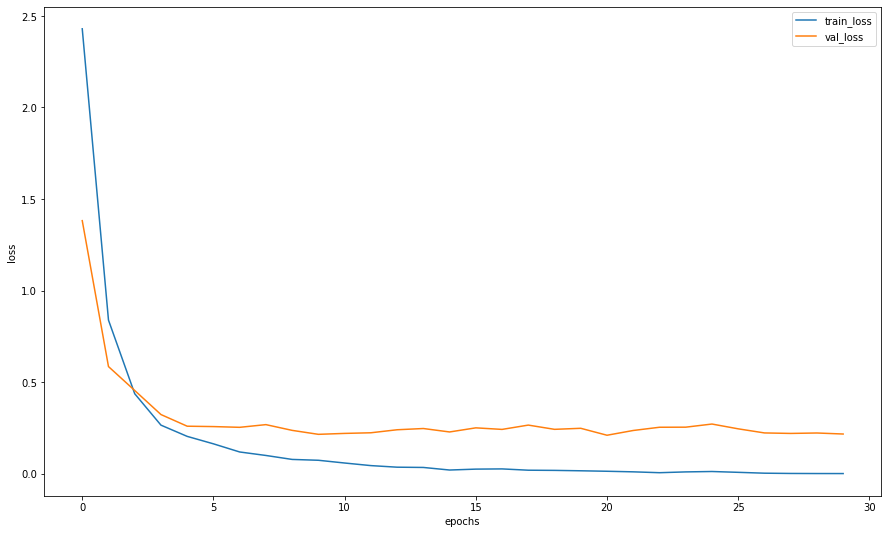

In [10]:
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

for fold, (train_idx, val_idx) in enumerate(skf.split(train_val_files, label_encoder.transform(train_val_labels))):
    print('\nFOLD', fold+1)
    val_dataset = SimpsonsDataset(np.array(train_val_files)[val_idx], mode='val')
    train_dataset = SimpsonsDataset(np.array(train_val_files)[train_idx], mode='train')
    
    clf = models.resnet18(pretrained=True)
    clf.fc = nn.Linear(in_features=clf.fc.in_features, out_features=n_classes)
    clf = clf.to('cuda')
        
    history = train(train_dataset, val_dataset, model=clf, epochs=EPOCHS, batch_size=BATCH_SIZE)
    loss, acc, val_loss, val_acc = zip(*history)
    plt.figure(figsize=(15, 9))
    plt.plot(loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()
    plt.close()
    
    probs = predict(clf, test_loader)
    preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))    
    submit[f'fold_{fold+1}'] = preds    
    break

In [11]:
torch.cuda.empty_cache()

###  Submission

In [12]:
test_filenames = [path.name for path in test_dataset.files]
submit['Id'] = test_filenames
submit['Expected'] = submit.mode(axis=1)[0]
submit[['Id', 'Expected']].to_csv('submission_resnet18_sgd_lrp3.csv', index=False)
submit.head()

,Id,fold_1,Expected
0,img0.jpg,nelson_muntz,img0.jpg
1,img1.jpg,bart_simpson,bart_simpson
2,img10.jpg,ned_flanders,img10.jpg
3,img100.jpg,chief_wiggum,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon,apu_nahasapeemapetilon
